### Train-test split

In [76]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols
import scipy.stats as stats
from pathlib import Path
from sklearn.model_selection import train_test_split

pd.set_option("display.max_columns", 500)

random_seed = 2024
np.random.seed(random_seed)

In [77]:
bottle_data_path = '../data/bottle'

In [78]:
bottle_df = pd.read_csv(f'{bottle_data_path}/bottle_01.csv', index_col=0)

In [79]:
bottle_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 147847 entries, 275679 to 536964
Data columns (total 16 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   R_Depth     147847 non-null  float64
 1   R_TEMP      145938 non-null  float64
 2   R_SALINITY  145628 non-null  float64
 3   R_SIGMA     145466 non-null  float64
 4   R_SVA       145466 non-null  float64
 5   R_DYNHT     145590 non-null  float64
 6   R_O2        145491 non-null  float64
 7   R_O2Sat     145003 non-null  float64
 8   R_SIO3      141915 non-null  float64
 9   R_PO4       140976 non-null  float64
 10  R_NO3       139747 non-null  float64
 11  R_NO2       136810 non-null  float64
 12  R_NH4       32077 non-null   float64
 13  R_CHLA      147845 non-null  float64
 14  R_PHAEO     147847 non-null  float64
 15  R_PRES      147847 non-null  float64
dtypes: float64(16)
memory usage: 19.2 MB


Perform a random train-test split of the data. R_PHAEO is a target feature here.

In [80]:
X_train, X_test, y_train, y_test = train_test_split(bottle_df.drop('R_PHAEO', axis=1), bottle_df['R_PHAEO'], test_size=0.2, random_state=random_seed)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(118277, 15) (29570, 15) (118277,) (29570,)


#### Distributions

(rearrange everything as in the example project, i.e. plots and transformations PER VARIABLE)

I would like to investigate a bit the distribution of columns in order to see if further adjustments are needed.

In [81]:
def hist_plot(X, f_size=(5, 3)):
    plt.figure(figsize=f_size)
    sns.histplot(data=X, kde=False, bins=50)
    plt.plot()

c:\Users\shele\anaconda3\envs\calcofi\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\shele\anaconda3\envs\calcofi\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\shele\anaconda3\envs\calcofi\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\shele\anaconda3\envs\calcofi\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future

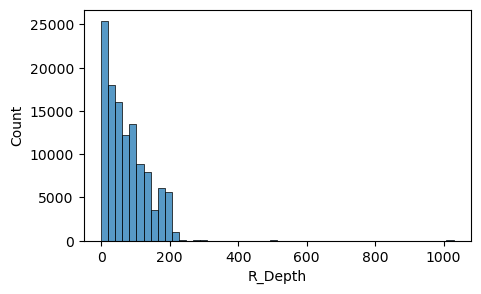

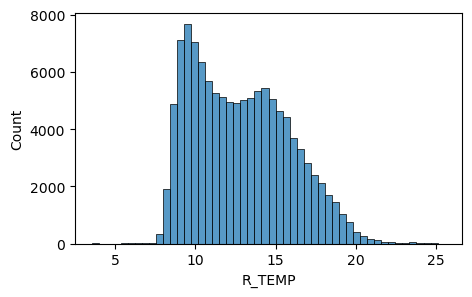

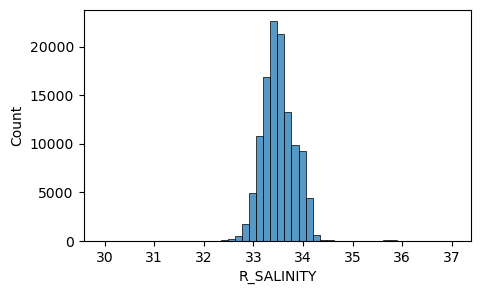

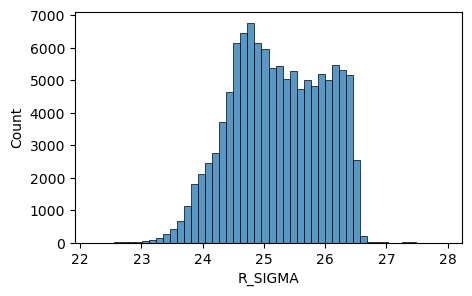

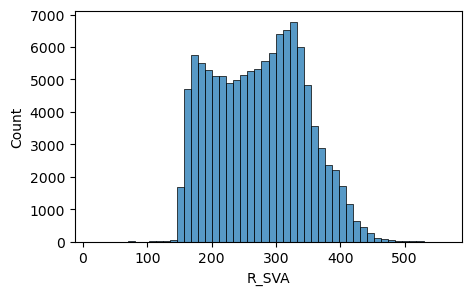

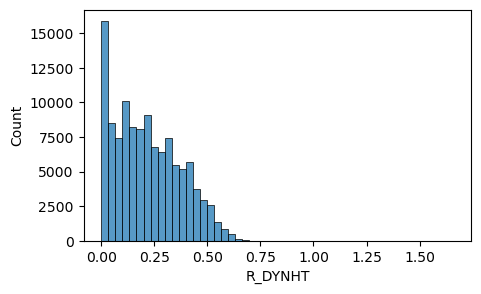

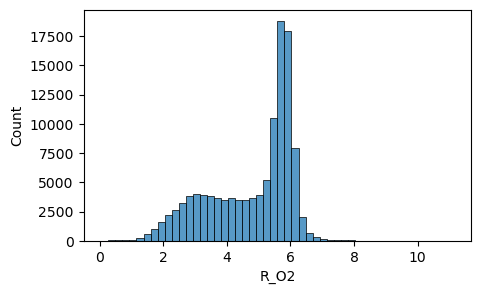

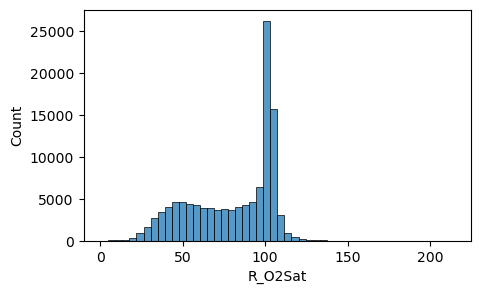

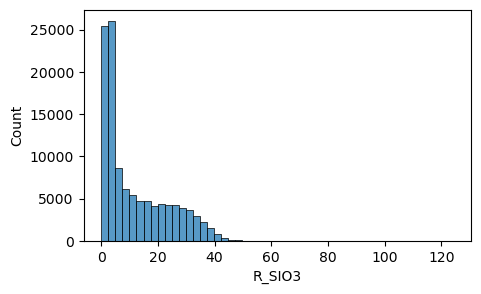

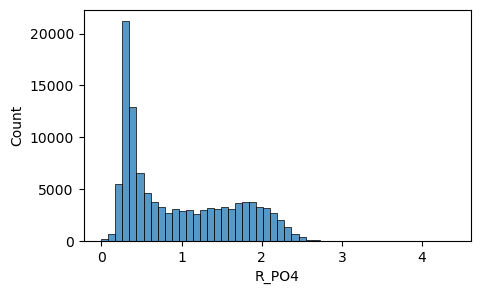

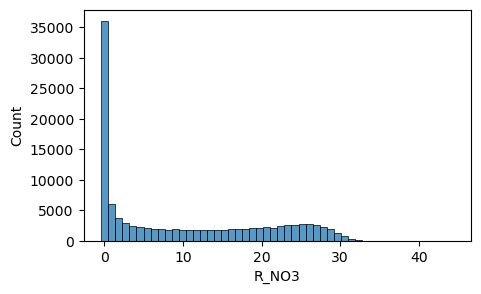

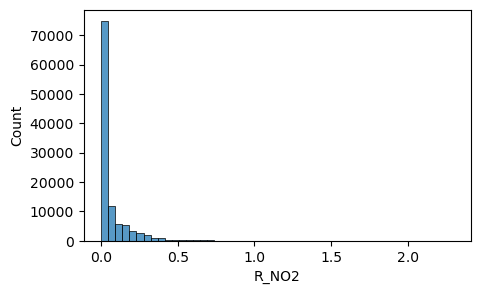

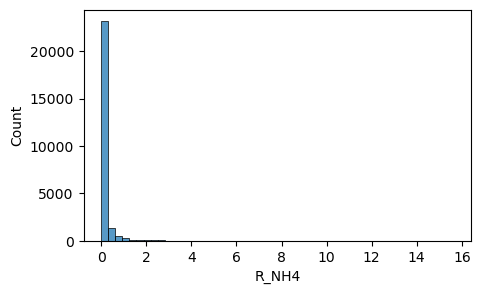

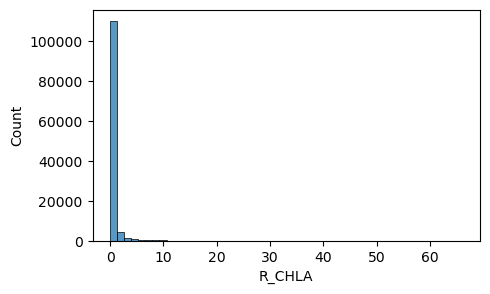

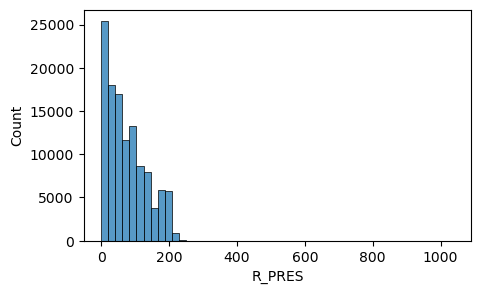

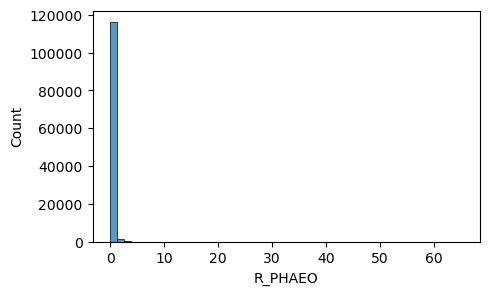

In [82]:
for col in X_train.columns:
    hist_plot(X_train[col])

hist_plot(y_train)

<!-- Some of the columns have two "modes" in their distributions. I think it is because of geographic location (California Coast VS Bay of California). NEED TO CHECK THIS!!! (add geographic data from Cast table).

Also, there are clear candidates for categorical features, e.g. R_PHAEO, where most of the values fall in the first near-zero bucket. I can work with this by creating new features. Then we can use classification algorithms for these variables, although a lot of NaNs can be a problem here (just an idea). -->

Let's take a closer look on a R_PHAEO distribution.

In [83]:
y_train.describe()

count    118277.000000
mean          0.212097
std           0.424060
min           0.000000
25%           0.050000
50%           0.120000
75%           0.250000
max          65.300000
Name: R_PHAEO, dtype: float64

In [84]:
y_train[y_train < y_train.quantile(0.99)].describe()

count    117084.000000
mean          0.185866
std           0.215363
min           0.000000
25%           0.050000
50%           0.110000
75%           0.240000
max           1.700000
Name: R_PHAEO, dtype: float64

c:\Users\shele\anaconda3\envs\calcofi\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


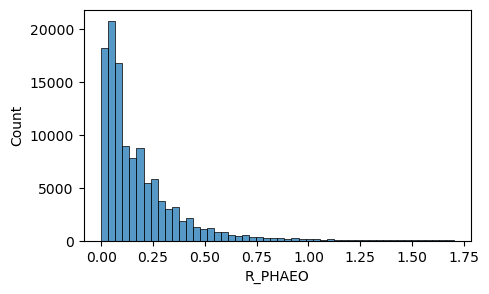

In [85]:
hist_plot(y_train[y_train < y_train.quantile(0.99)])
